# Project Overview

### Description

Experimental data used to create regression models of appliances energy use in a low energy building.

### Summary

Experimental data used to create regression models of appliances energy use in a low energy building.

**Source:**
Luis Candanedo, luismiguel.candanedoibarra '@' umons.ac.be, University of Mons (UMONS).

### Dataset Information

The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station ***(Chievres Airport, Belgium)*** was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non predictive attributes (parameters).

### Attribute Information

1. **date:** year-month-day hour:minute:second 
2. **Appliances:** energy use in Wh (watt-hour)
3. **lights:** energy use of light fixtures in the house in Wh (watt-hour)
4. **T1:** Temperature in kitchen area, in Celsius
5. **RH_1:** Humidity in kitchen area, in %
6. **T2:** Temperature in living room area, in Celsius
7. **RH_2:** Humidity in living room area, in %
8. **T3:** Temperature in laundry room area
9. **RH_3:** Humidity in laundry room area, in %
10. **T4:** Temperature in office room, in Celsius
11. **RH_4:** Humidity in office room, in %
12. **T5:** Temperature in bathroom, in Celsius
13. **RH_5:** Humidity in bathroom, in %
14. **T6:** Temperature outside the building (north side), in Celsius
15. **RH_6:** Humidity outside the building (north side), in %
16. **T7:** Temperature in ironing room , in Celsius
17. **RH_7:** Humidity in ironing room, in %
18. **T8:** Temperature in teenager room 2, in Celsius
19. **RH_8:** Humidity in teenager room 2, in %
20. **T9:** Temperature in parents room, in Celsius
21. **RH_9:** Humidity in parents room, in %
22. **To:** Temperature outside (from Chievres weather station), in Celsius
23. **Pressure:** (from Chievres weather station), in mm Hg
24. **RH_out:** Humidity outside (from Chievres weather station), in %
25. **Wind speed:** (from Chievres weather station), in m/s
26. **Visibility:** (from Chievres weather station), in km
27. **Tdewpoint:** (from Chievres weather station), Ã‚Â°C
28. **rv1:** Random variable 1, nondimensional
29. **rv2:** Random variable 2, nondimensional

Where indicated, hourly data (then interpolated) from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis, rp5.ru. Permission was obtained from Reliable Prognosis for the distribution of the 4.5 months of weather data.

### 1. Import packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn import decomposition
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import warnings
warnings.filterwarnings('ignore')

# Set theme of plot
sns.set_theme(style="whitegrid")

### 2. Read the data

In [2]:
df = pd.read_csv('./data/energydata_complete.csv')

df['date'] = pd.to_datetime(df['date'])
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         19735 non-null  datetime64[ns]
 1   Appliances   19735 non-null  int64         
 2   lights       19735 non-null  int64         
 3   T1           19735 non-null  float64       
 4   RH_1         19735 non-null  float64       
 5   T2           19735 non-null  float64       
 6   RH_2         19735 non-null  float64       
 7   T3           19735 non-null  float64       
 8   RH_3         19735 non-null  float64       
 9   T4           19735 non-null  float64       
 10  RH_4         19735 non-null  float64       
 11  T5           19735 non-null  float64       
 12  RH_5         19735 non-null  float64       
 13  T6           19735 non-null  float64       
 14  RH_6         19735 non-null  float64       
 15  T7           19735 non-null  float64       
 16  RH_7

***Initial Observation:***

 - No null values
 - 19735 rows and 29 features
 - All are numerical features
 - Dataset contains temperature, humidity and weather information
 - 2 random variables (non-dimensional) are given to filter non-predictive attributes

In [4]:
# Check if any rows are duplicated!

print(f'Duplicate rows: {df.duplicated().sum()}')

Duplicate rows: 0


In [5]:
# Check if any columns are duplicated!
temp_df = df.copy()
cols = temp_df.columns.tolist()

# rv1, rv2 are the same! TODO: Check if it has any impact on model performance
print(f'Duplicate columns: {temp_df.T.duplicated().sum()}')

Duplicate columns: 1


#### Treat Datetime feature

In [6]:
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute

df.drop('date', axis=1, inplace=True)
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,month,day,hour,minute
0,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,92.0,7.000000,63.000000,5.3,13.275433,13.275433,1,11,17,0
1,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,92.0,6.666667,59.166667,5.2,18.606195,18.606195,1,11,17,10
2,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,92.0,6.333333,55.333333,5.1,28.642668,28.642668,1,11,17,20
3,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,92.0,6.000000,51.500000,5.0,45.410389,45.410389,1,11,17,30
4,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,92.0,5.666667,47.666667,4.9,10.084097,10.084097,1,11,17,40


### 3. Exploratory Data Analysis (EDA)

In [7]:
df.columns

Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'rv1', 'rv2', 'month', 'day', 'hour', 'minute'],
      dtype='object')

In [8]:
df.shape

(19735, 32)

#### Energy Usage of Appliances (Hourly, Daily, Monthly)

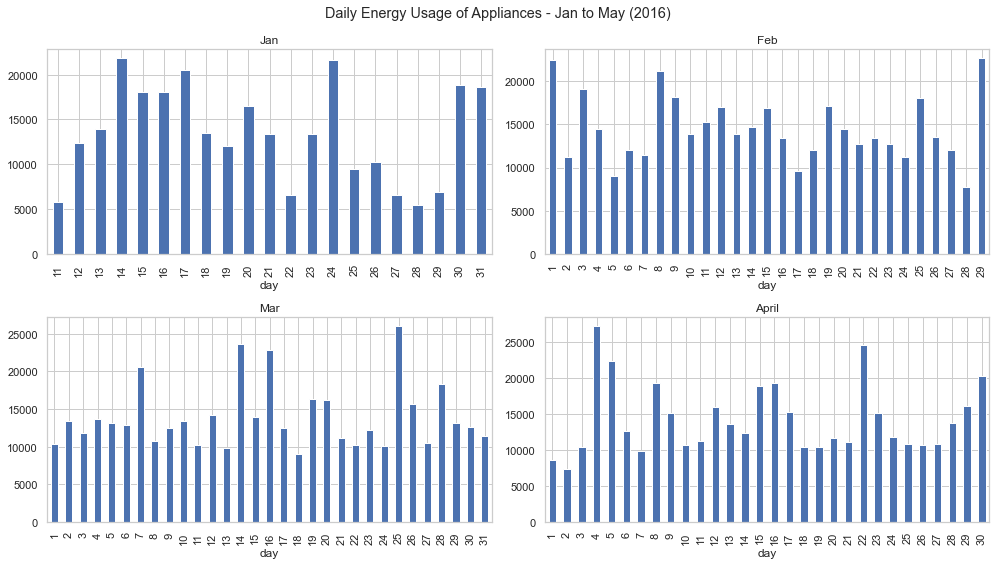

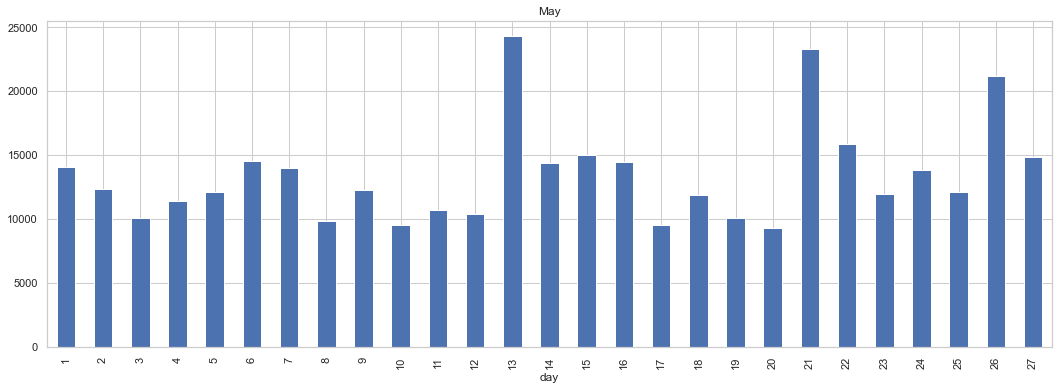

In [9]:
# Daily energy usage
fig, ax = plt.subplots(2, 2, figsize=(14, 8))
ax = ax.flatten()

months = ['Jan', 'Feb', 'Mar', 'April']
for i in range(1, 5):
    df.query(f"month == {i}")[['day', 'Appliances']].groupby('day')['Appliances'].sum().plot.bar(ax=ax[i-1], title=months[i-1])
    
plt.suptitle('Daily Energy Usage of Appliances - Jan to May (2016)')
plt.tight_layout()
plt.show()

# Plotting May month's usage
plt.figure(figsize=(18, 6))
df.query("month == 5")[['day', 'Appliances']].groupby('day')['Appliances'].sum().plot.bar(title='May')
plt.show()

***Insights***
 - Weekend energy usage is more or less higher compare to average day. E.g. Jan
 - Certain months shows high energy usage for pre-weekend day. Could be party, enjoyment etc.

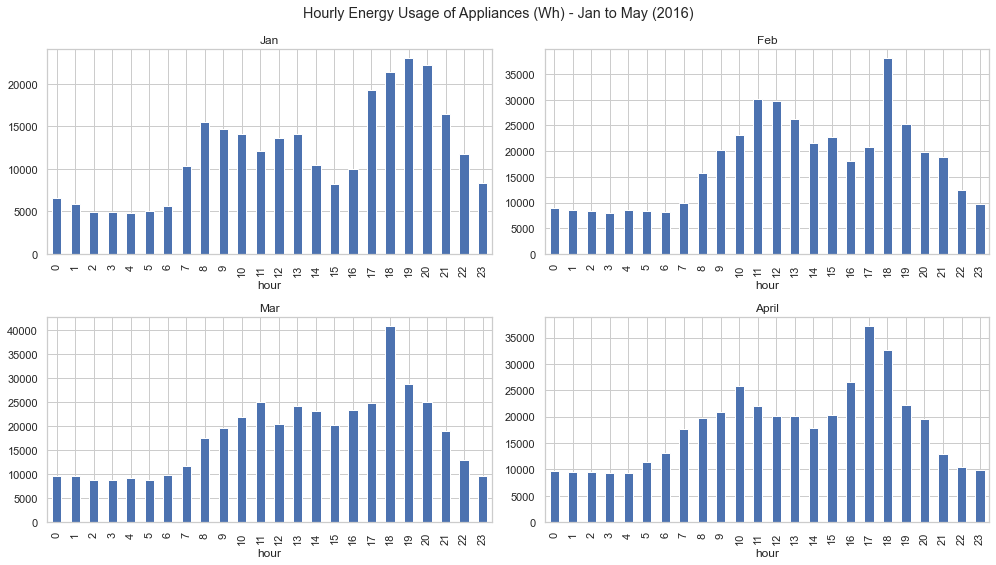

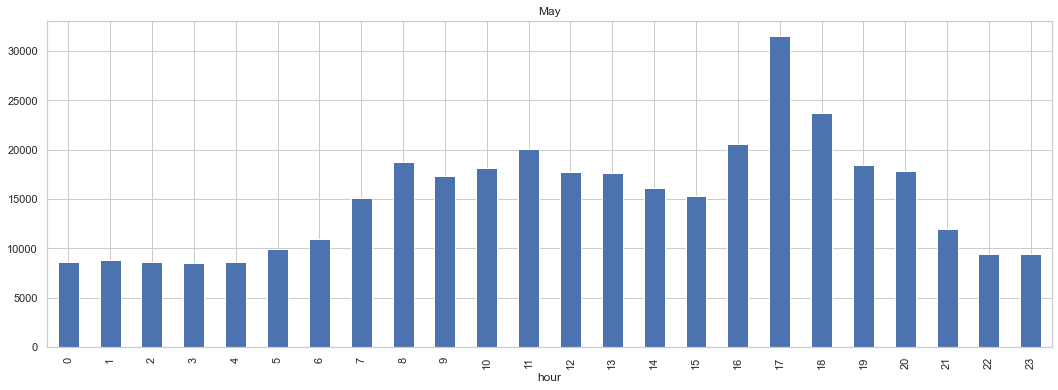

In [10]:
# Hourly energy usage
fig, ax = plt.subplots(2, 2, figsize=(14, 8))
ax = ax.flatten()

months = ['Jan', 'Feb', 'Mar', 'April']
for i in range(1, 5):
    df.query(f"month == {i}")[['hour', 'Appliances']].groupby('hour')['Appliances'].sum().plot.bar(ax=ax[i-1], title=months[i-1])
    
plt.suptitle('Hourly Energy Usage of Appliances (Wh) - Jan to May (2016)')
plt.tight_layout()
plt.show()

# Plotting May month's usage
plt.figure(figsize=(18, 6))
df.query("month == 5")[['hour', 'Appliances']].groupby('hour')['Appliances'].sum().plot.bar(title='May')
plt.show()

***Insights***
 - Peak hours for maximum energy usage between 7-14 and 17-22 daily
 - Lowest energy usage during night hours (0-6)

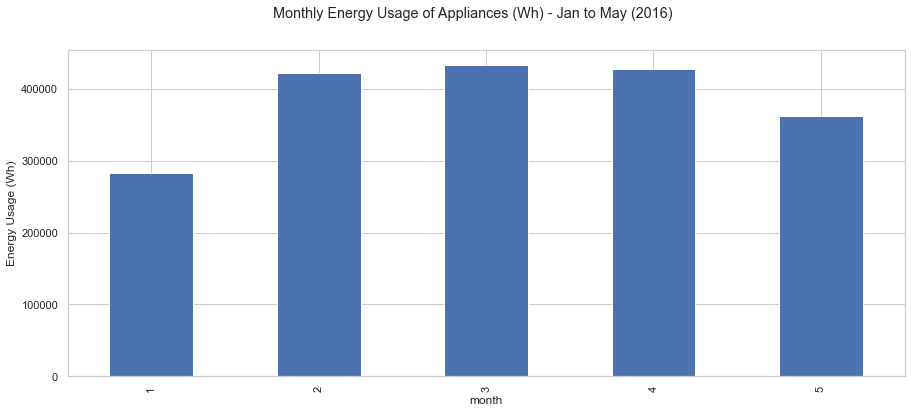

In [11]:
# Monthly energy usage
plt.figure(figsize=(15, 6))
df.groupby('month')['Appliances'].sum().plot.bar()
plt.suptitle('Monthly Energy Usage of Appliances (Wh) - Jan to May (2016)')
plt.ylabel('Energy Usage (Wh)')
plt.show()

***Insights***
 - Energy usage in March month is higher comparatively because its a peak summer month

In [12]:
def ts_plot(df: pd.DataFrame, cols: list, nrows: int, ncols: int, labels: list, title: str) -> None:
    """General function to plot temperature and humidity
    
    Args:
        df (pd.DataFrame): Dataframe
        cols (list): List of columns to plot
        nrows (int): Number of rows for subplot
        ncols (int): Number of columns for subplot
        labels (list): Labels of the plot
        title (str): Title of the plot
    """
    fig, ax = plt.subplots(nrows, ncols, figsize=(15, 8))
    ax = ax.flatten()

    for i, icol in enumerate(cols):
        sns.lineplot(data=df[icol], ax=ax[i], label=labels[i])
        #ax[i].axhline(mean_temp, color='r', linestyle='--')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [13]:
labels = ['Kitchen', 'Living Room', 'Laundry Room', 'Office', 'Bathroom', 
              'Outside of Building (North side)', 'Ironing Room', 'Teenager Room', 
              'Parents Room']

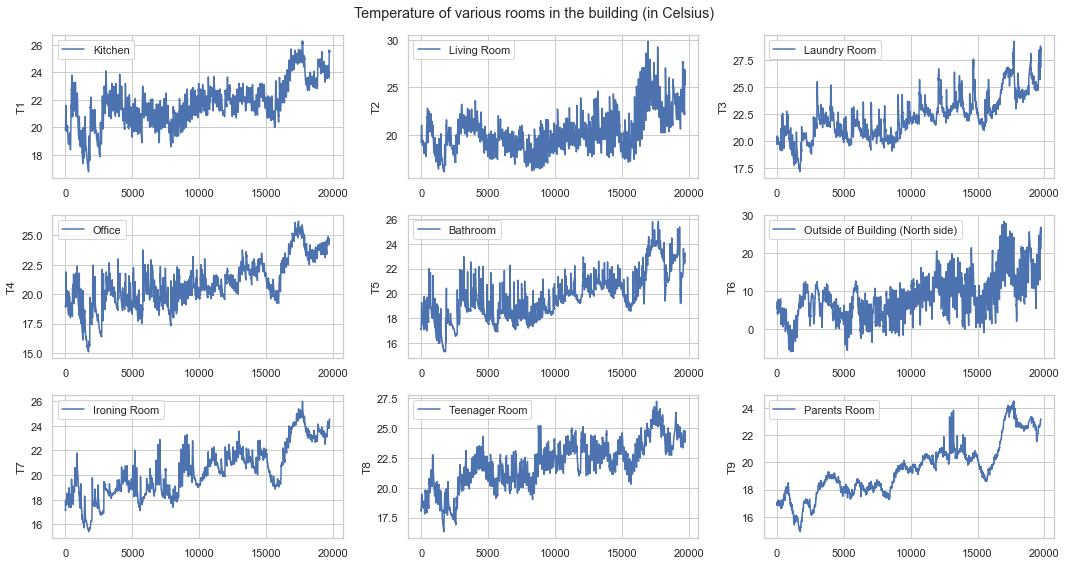

In [14]:
# Plot temperature features
temp_cols = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9']

ts_plot(df, temp_cols, 3, 3, labels, title='Temperature of various rooms in the building (in Celsius)')

***Insights***

 - All the temperature readings have upward trends from Jan to May (Winter to Summer -- Temperature increases - 2016)

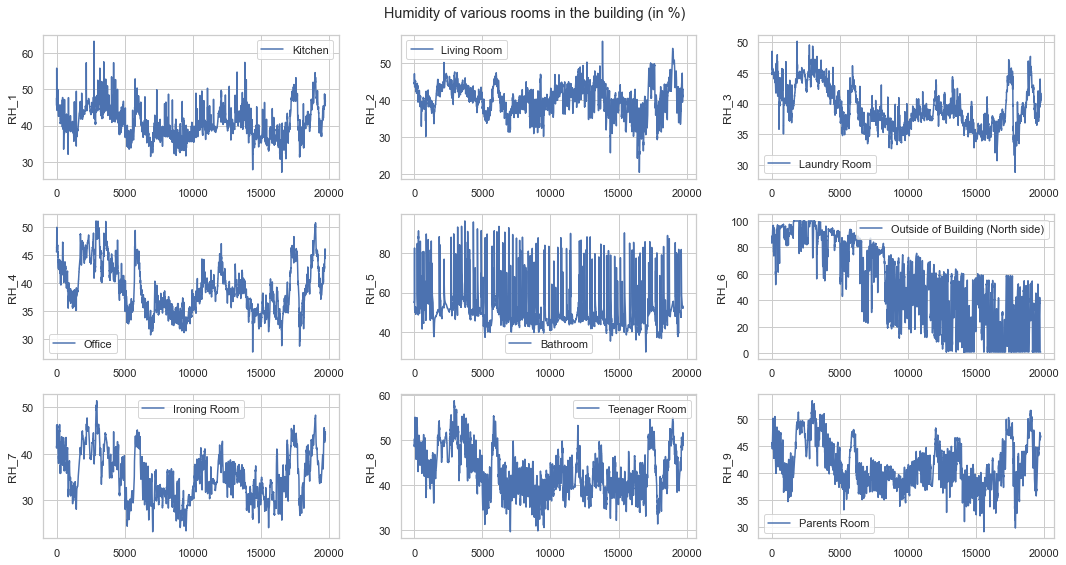

In [15]:
# Plot humidity features
humd_cols = ['RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_6', 'RH_7', 'RH_8', 'RH_9']

ts_plot(df, humd_cols, 3, 3, labels, title='Humidity of various rooms in the building (in %)')

***Insights***

 - Humidity measurements inside the building is more or less constant (e.g. no trend observed).
 - Humidity outside the Building (North side) is decreased over the time (from Jan to May) which is strange as humidity is lower in winter and higher in summer.

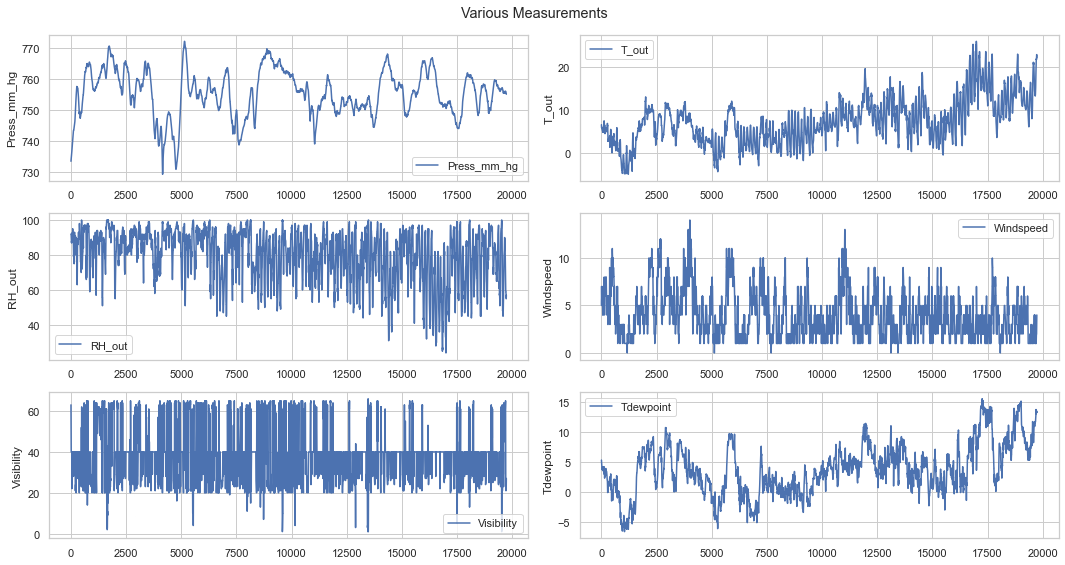

In [16]:
# Plot features other than temperature and humidity
cols = ['Press_mm_hg', 'T_out', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint']

ts_plot(df, cols, 3, 2, cols, title='Various Measurements')

***Insights***

 - There's not trend in pressure, visibility, humidity (outside of the building) and windspeed.
 - Outside temperature and dew point have upward trend (from Jan to May)

### 5. Spliting data into train and test

In [17]:
# Spliting dataset into train and test

df_train, df_test = train_test_split(df, test_size=0.20, random_state=0)
print(df_train.shape, df_test.shape)

(15788, 32) (3947, 32)


### 6. Feature Analysis

In [18]:
# Checking zero variance columns

num_zero_var = 0
for i, icol in enumerate(df_train.columns[1:]):   # Skip date column
    
    if df_train[icol].var() == 0:
        num_zero_var += 1
        
print(f'Total {num_zero_var} columns have zero variance')

Total 0 columns have zero variance


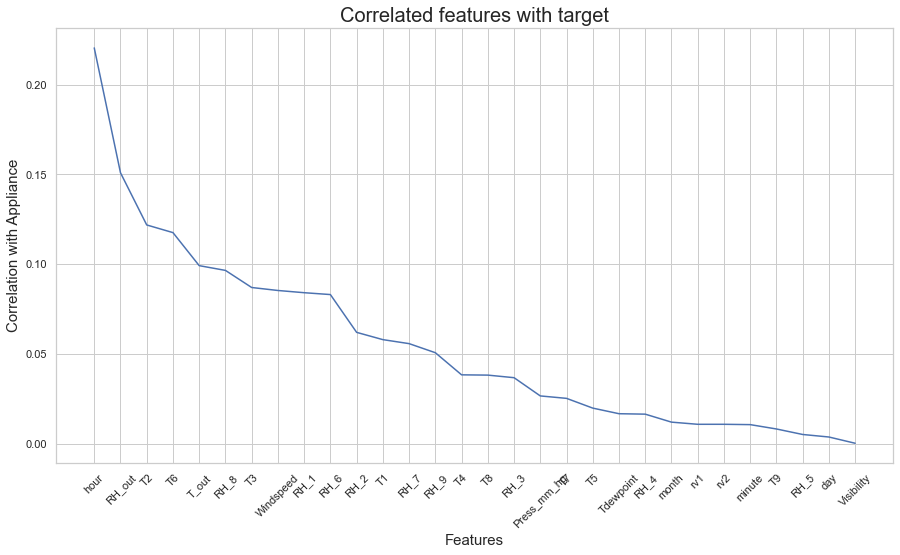

In [19]:
# Most correlated features

temp_df = df_train.drop('Appliances', axis=1)
corr_df = pd.DataFrame({'cols': temp_df.columns[1:]})
corr_df['val'] = 0

for i, icol in enumerate(corr_df['cols'].values):
    corr_df.iloc[i, 1] = abs(df_train['Appliances'].corr(temp_df[icol]))  # Accounting absolute correlation

corr_df = corr_df.sort_values(by=['val'], ascending=False).dropna()

plt.figure(figsize=(15, 8))
plt.plot(corr_df.cols, corr_df.val)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation with Appliance', fontsize=15)
plt.title('Correlated features with target', fontsize=20)
plt.xticks(rotation=45)
plt.show()

***Insights***

 - Lights is highly correlated feature with Appliances
 - Visibility is least correlated feature with Appliance

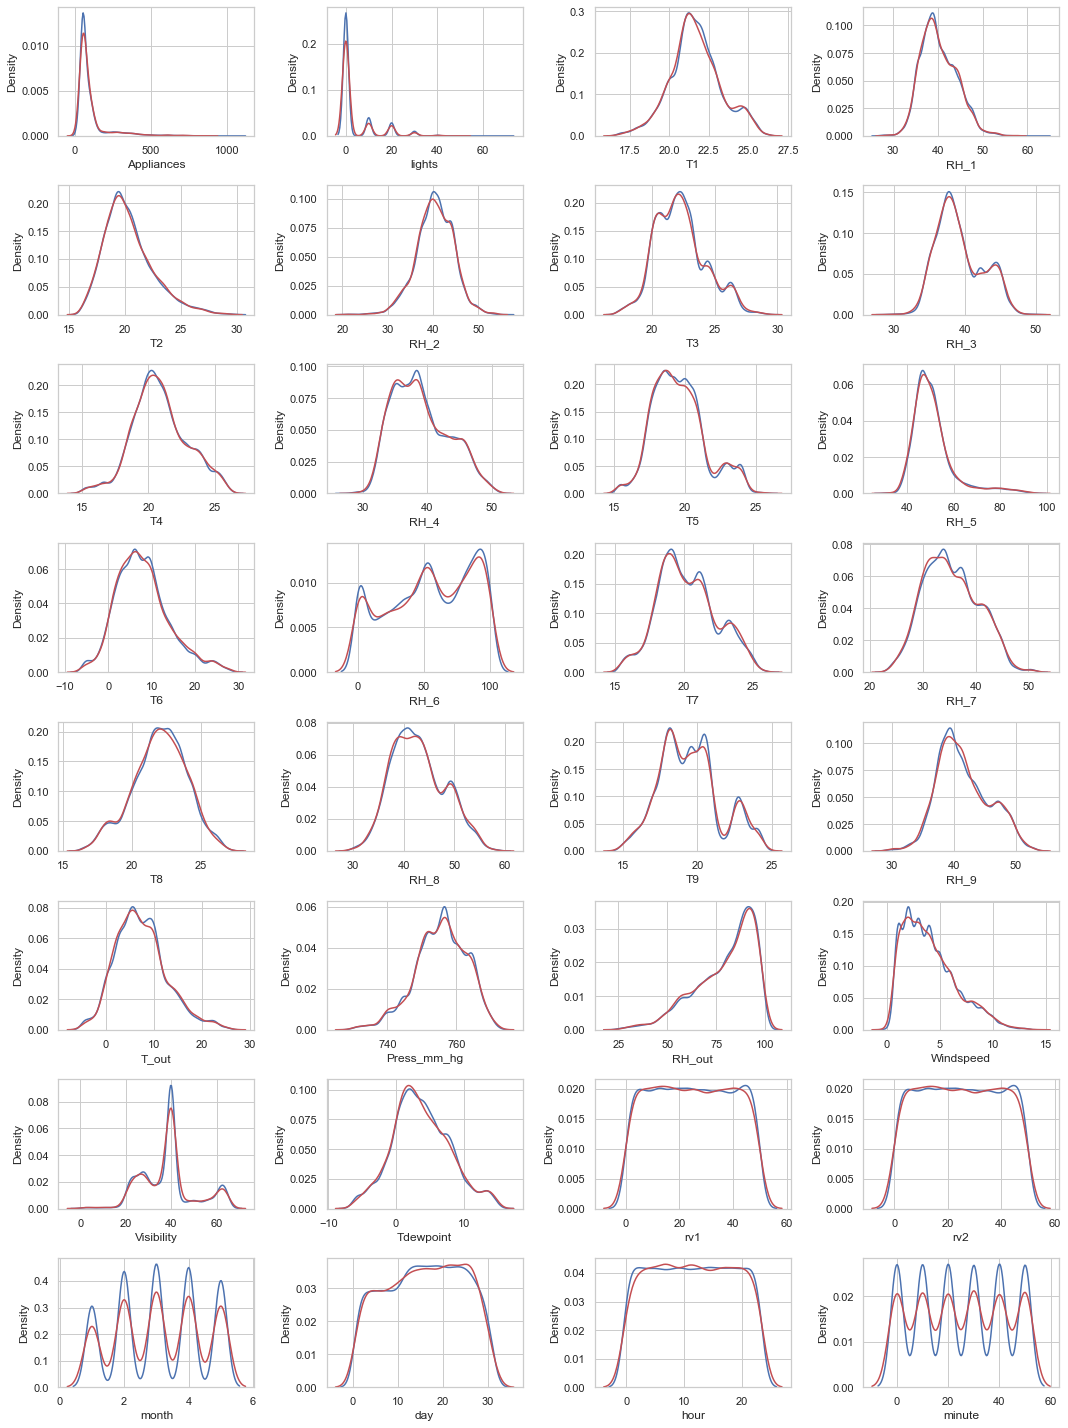

In [20]:
# Check for distribution of train and test data for all the features

fig, ax = plt.subplots(8, 4, figsize=(15, 20))
ax = ax.flatten()

for i, icol in enumerate(df_train.columns):
    sns.kdeplot(data=df_train, x=icol, color='b', ax=ax[i])
    sns.kdeplot(data=df_test, x=icol, color='r', ax=ax[i])
    
plt.tight_layout()
plt.show()

***Insights***

 - Here Appliances is the target variable with positively skewed distribution
 - lights also has positively skewed distribution
 - Rest of the features are normally distributed
 - Also, train and test split are rantom so we don't have any dataset shifts/covariate shifts which we can see in above distribution plots.
 

#### Correlation with target

In [21]:
df_temp = df.copy()
df_temp['Appliances'] = df['Appliances']

crr_mat = df_temp.corr()
crr_mat['Appliances'].sort_values(ascending=False)

Appliances     1.000000
hour           0.216792
lights         0.197278
T2             0.120073
T6             0.117638
T_out          0.099155
Windspeed      0.087122
RH_1           0.086031
T3             0.085060
T1             0.055447
T4             0.040281
T8             0.039572
RH_3           0.036292
T7             0.025801
T5             0.019760
RH_4           0.016965
Tdewpoint      0.015353
minute         0.013216
T9             0.010010
RH_5           0.006955
day            0.002366
Visibility     0.000230
rv1           -0.011145
rv2           -0.011145
month         -0.011606
Press_mm_hg   -0.034885
RH_9          -0.051462
RH_7          -0.055642
RH_2          -0.060465
RH_6          -0.083178
RH_8          -0.094039
RH_out        -0.152282
Name: Appliances, dtype: float64

In [22]:
df.Appliances.max()

1080

In [23]:
df.lights.value_counts()

0     15252
10     2212
20     1624
30      559
40       77
50        9
70        1
60        1
Name: lights, dtype: int64

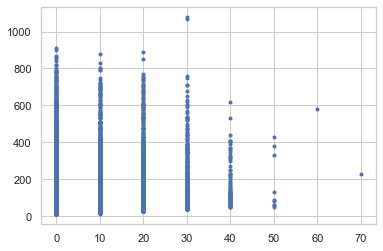

In [24]:
plt.plot(df.lights, df.Appliances, 'b.')
plt.show()

### 7. Data Transformation

In [25]:
# Seperate features and target variable for both train and test data

drop_cols = ['Appliances', 'rv1', 'rv2']
X_train = df_train.drop(drop_cols, axis=1)
y_train = df_train['Appliances']

X_test = df_test.drop(drop_cols, axis=1)
y_test = df_test['Appliances']

print(f'Train data: {X_train.shape, y_train.shape}')
print(f'Test data: {X_test.shape, y_test.shape}')

Train data: ((15788, 29), (15788,))
Test data: ((3947, 29), (3947,))


In [26]:
# Feature scaling
# Reference: https://stackoverflow.com/questions/49444262/normalize-data-before-or-after-split-of-training-and-testing-data

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_train.shape, X_test.shape)

(15788, 29) (3947, 29)


### 8. Feature Selection

In [ ]:
# rfecv
rfe_estimator = RandomForestRegressor()
rfecv_1 = RFECV(rfe_estimator, step=1, min_features_to_select=1, scoring='r2', verbose=12, n_jobs=-1)
rfecv_1.fit(X_train, y_train)
X_rfe = rfecv_1.transform(X_train)

plt.plot(rfecv_1.grid_scores_[:])
plt.show()

### 9. Model Building and Evaluation

In [27]:
lr = LinearRegression() # Ridge()
lr.fit(X_train, y_train)

# #To retrieve the intercept:
# print(lr.intercept_)
# #For retrieving the slope:
# print(lr.coef_)
y_pred = lr.predict(X_test)
print(y_test.shape, y_pred.shape)

print(f'Training R2 score (LR): {r2_score(y_train, lr.predict(X_train))}')
print(f'Validation R2 Score (LR): {r2_score(y_test, y_pred)}')

(3947,) (3947,)
Training R2 score (LR): 0.1726308587897043
Validation R2 Score (LR): 0.15455556282105876


In [28]:
xgb = XGBRegressor() # Ridge()
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
print(y_test.shape, y_pred.shape)

print(f'Training R2 score (XGB): {r2_score(y_train, xgb.predict(X_train))}')
print(f'Validation R2 Score (XGB): {r2_score(y_test, y_pred)}')

(3947,) (3947,)
Training R2 score (XGB): 0.8529706790321484
Validation R2 Score (XGB): 0.4783994155296647


### 10. Conclusion